In [ ]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

# Dataset

FER -2013 - The dataset contains 35,887 grayscale images, each with a resolution of 48x48 pixels. There are seven categories of emotion labels : angry, disgust, fear, happy, sad, surprise, and neutral.

In [ ]:
df = pd.read_csv('/Users/manovah/Downloads/FER 2013/fer2013/fer2013/fer2013.csv')

df.head()
df.drop(columns=['Usage'])
print(df.shape)


(35887, 3)


In [ ]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

Majority classes belongs to 3:happiness, 4:Sadness and 6:Neutral



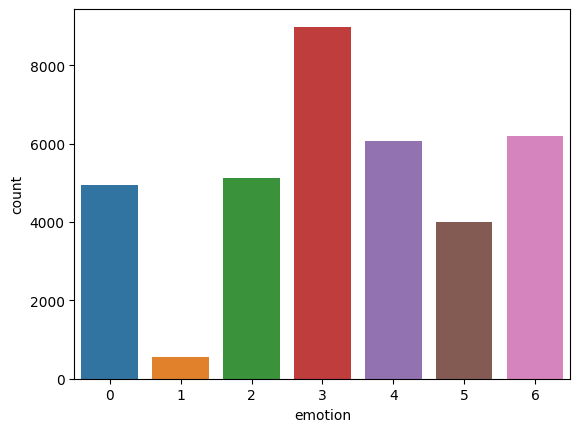

In [ ]:
sns.countplot(x=df.emotion)
pyplot.show()

Sample images from the dataset

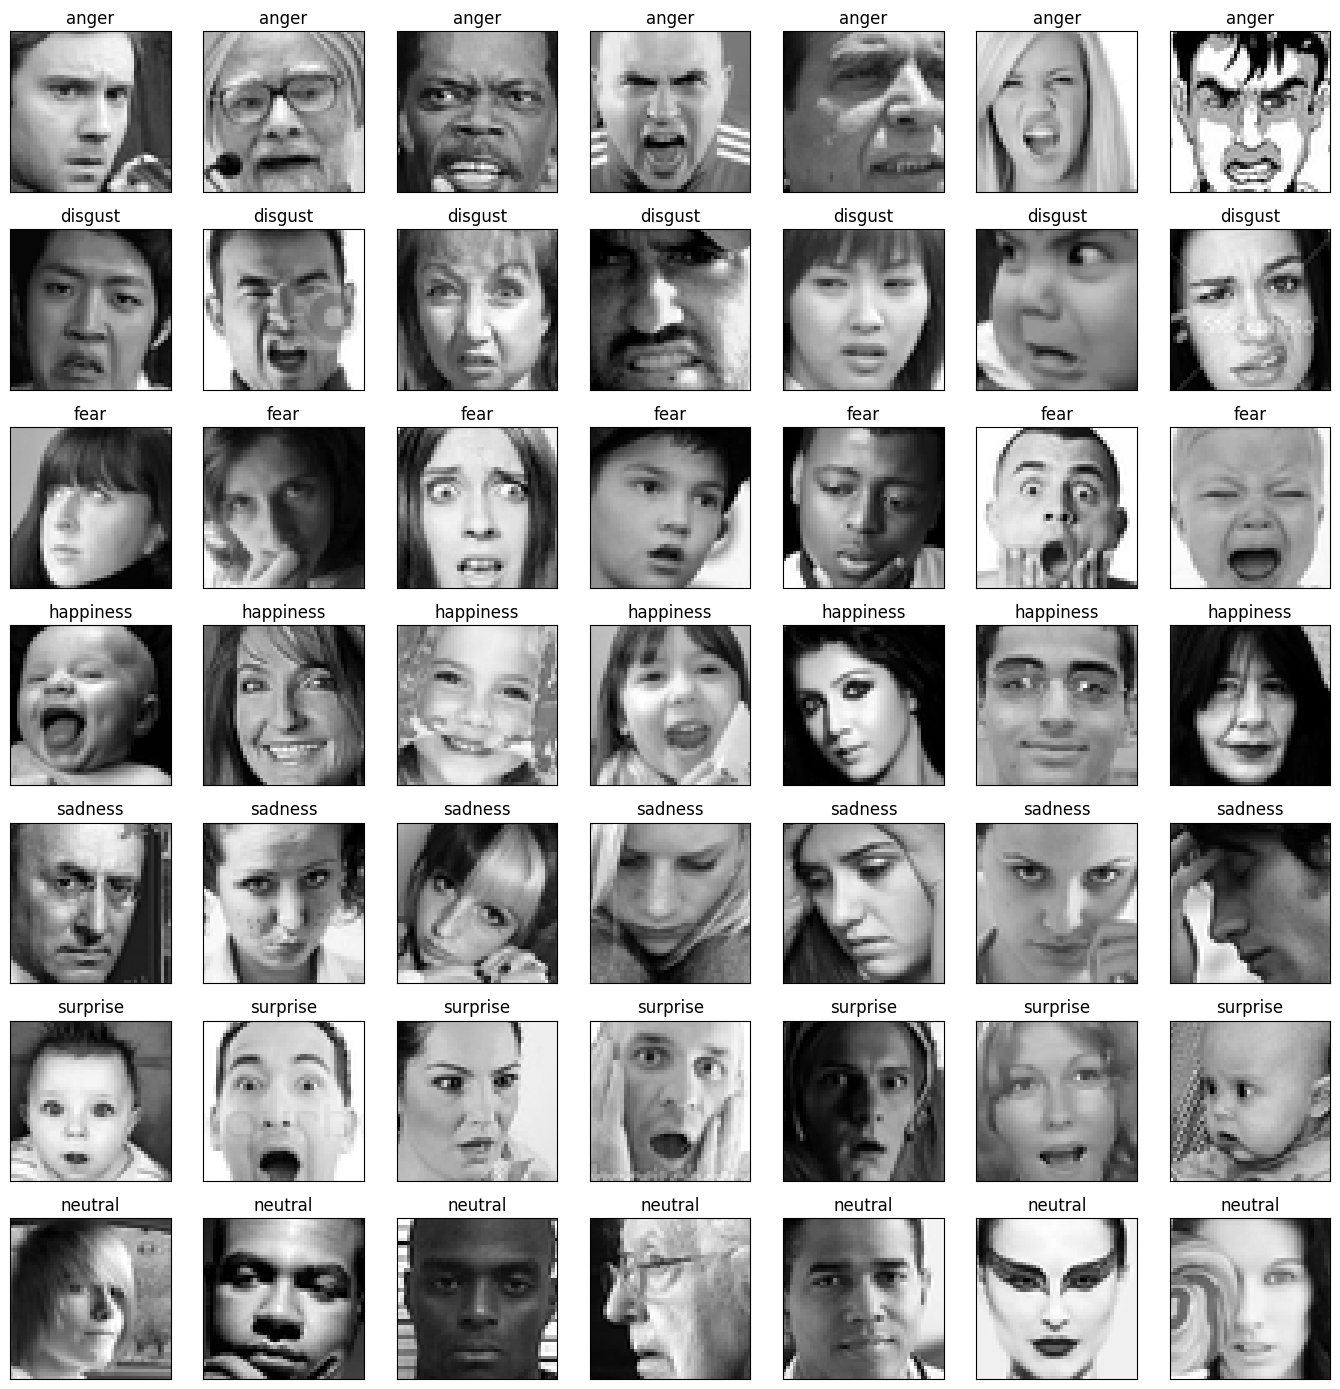

In [ ]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [ ]:
INTERESTED_LABELS = [0, 1, 2, 3, 4, 5 , 6]

In [ ]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(35887, 3)

`Reshape the datasource,to make it compatabile for the DenseNet model`

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [ ]:
img_array.shape

(35887, 48, 48, 1)

In [ ]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


`Splitting the data into training and validation set.`

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 1), (3589, 48, 48, 1), (32298, 7), (3589, 7))

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
def dense_net(optim):
    net = Sequential(name='DenseNet')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [ ]:
"""
used two callbacks during the training of the model: 
EarlyStopping to prevent overfitting on the training data, and 
ReduceLROnPlateau to adjust the learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

`As the data in hand is less as compared to the task so ImageDataGenerator is used.ImageDataGenerator is used to generate batches of augmented images for training deep learning models.`

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [ ]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

model = dense_net(optims[1]) 

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=False
)

Metal device set to: Apple M2 Pro


Model: "DenseNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0  

2023-04-18 19:09:53.994582: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100- lr: 0.0010
1009/1009 [==============================] - 16s 28ms/step - loss: 1.3308 - accuracy: 0.3972 - val_loss: 1.0491 - val_accuracy: 0.4692- lr: 0.0010
Epoch 2/100- lr: 0.0010
1009/1009 [==============================] - 13s 21ms/step - loss: 1.0338 - accuracy: 0.4780 - val_loss: 0.9268 - val_accuracy: 0.5538- lr: 0.0010
Epoch 3/100- lr: 0.0010
1009/1009 [==============================] - 13s 21ms/step - loss: 0.9482 - accuracy: 0.5362 - val_loss: 0.8188 - val_accuracy: 0.6206- lr: 0.0010
Epoch 4/100- lr: 0.0010
1009/1009 [==============================] - 13s 22ms/step - loss: 0.8476 - accuracy: 0.5996 - val_loss: 0.7366 - val_accuracy: 0.6718- lr: 0.0010
Epoch 5/100- lr: 0.0010
1009/1009 [==============================] - 13s 21ms/step - loss: 0.7788 - accuracy: 0.6408 - val_loss: 0.7047 - val_accuracy: 0.6827- lr: 0.0010
Epoch 6/100- lr: 0.0010
1009/1009 [==============================] - 14s 23ms/step - loss: 0.7294 - accuracy: 0.6694 - val_loss: 0.6432 - val_acc

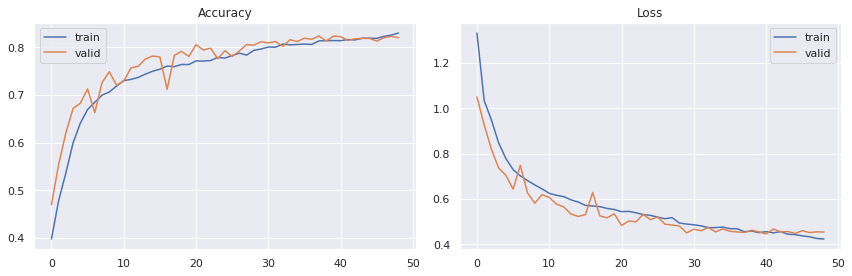

In [ ]:
sns.set()
fig = pyplot.figure(figsize=(12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('denseNet.png')
pyplot.show()

`The epochs history shows that accuracy gradually increases and achieved +83% accuracy on both training and validation set`

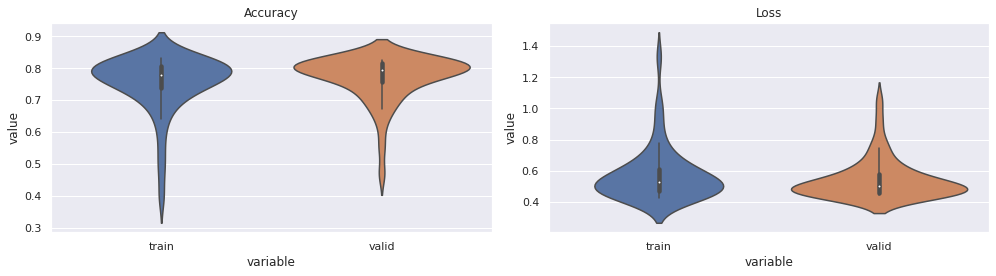

In [ ]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

113/113 [==============================] - 5s 38ms/step


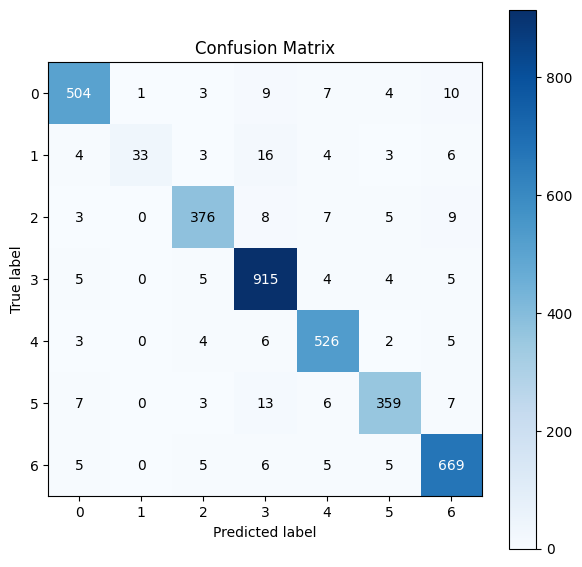

In [ ]:
predict_x=model.predict(X_valid) 
classes_x=np.argmax(predict_x,axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), classes_x, figsize=(7,7))
pyplot.savefig("confusion_matrix_densenet.png")

`Based on the confusion matrix, it is evident that the model is performing well on the happiness class but not as well on the other two classes. It is possible that this discrepancy could be attributed to the lack of data for these two classes. However, upon closer inspection of the images, it was found that some of the images in these classes were challenging even for human interpretation, as the individual facial expressions can vary. Specifically, some individuals' neutral expressions can be mistaken as sad due to their unique facial features.`

In [ ]:
print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != classes_x)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), classes_x))

total wrong validation predictions: 240


              precision    recall  f1-score   support

           0       0.72      0.71      0.75       899
           1       0.77      0.76      0.77       608
           2       0.73      0.76      0.75       620
           3       0.93      0.91      0.92       899
           4       0.83      0.83      0.84       608
           5       0.73      0.76      0.75       400
           6       0.73      0.76      0.75       620

    accuracy                           0.82      3589
   macro avg       0.81      0.81      0.81      3589
weighted avg       0.83      0.82      0.82      3589



In [ ]:
mapper = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

1/1 [==============================] - 0s 15ms/step


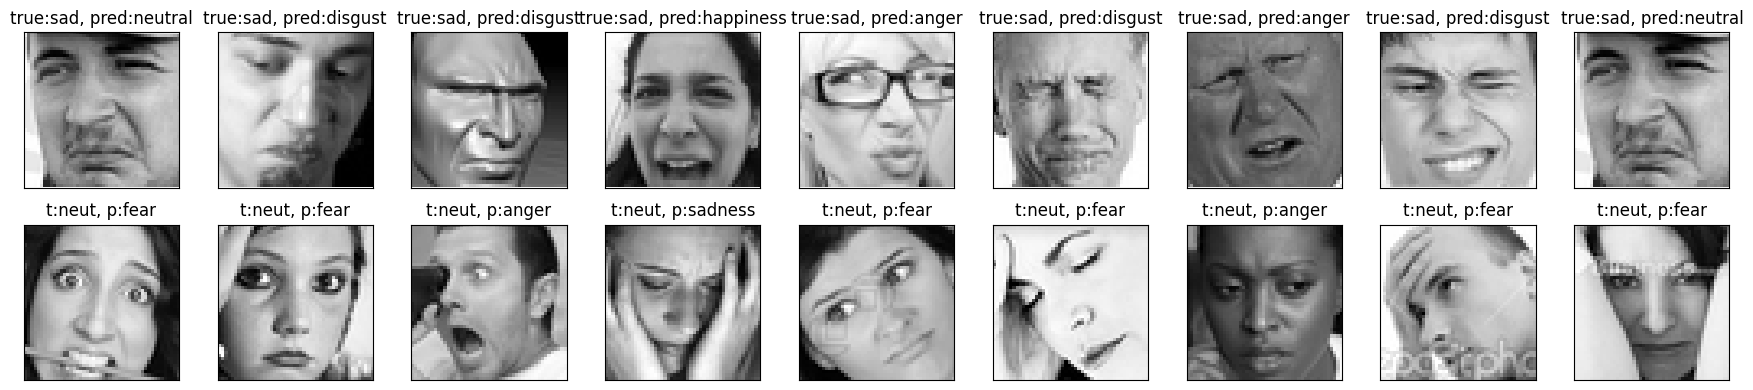

In [ ]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1)))]}")
        
        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neut, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1)))]}")


        pyplot.tight_layout()

# Model Exporting
The Built Model is then exported in tflite format(light weight) ,which is then integrated into the react native mobile application

In [ ]:
# convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# save the TFLite model to disk
with open('/Users/manovah/Documents/model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/x2/13m0dbk170gg_cpn8cx9f_2w0000gn/T/tmppqwbc2vj/assets


INFO:tensorflow:Assets written to: /var/folders/x2/13m0dbk170gg_cpn8cx9f_2w0000gn/T/tmppqwbc2vj/assets
2023-04-19 00:29:46.167701: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-04-19 00:29:46.167717: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.



# Android Application

As discussed the mobile application apk and source code , can be found under Android Folder. Below is the screenshot of the model processing the live camera feed from the mobile application and detecting emotions


<image  src="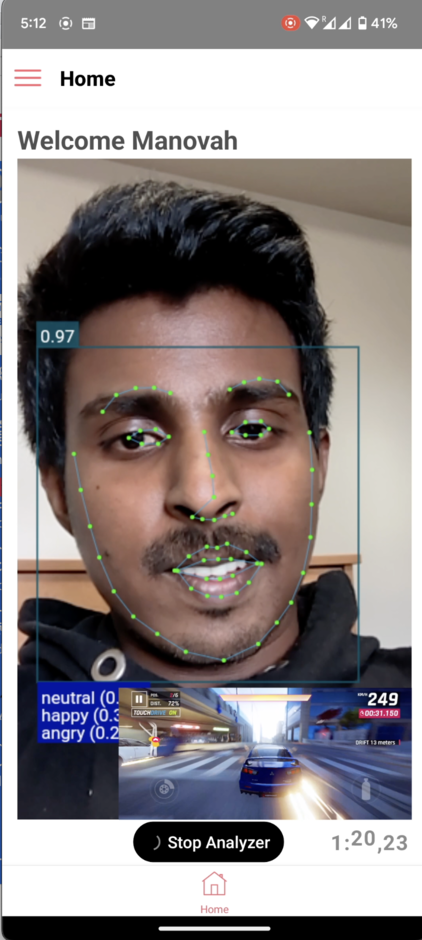"></image>